In [1]:
import numpy as np
import cvxpy as cp

In [9]:
import numpy as np


import gymnasium as gym
import torch

from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import static_error
from tensoraerospace.agent.mpc.gradient import MPCOptimizationAgent
from tensoraerospace.signals.random import full_random_signal
from tensoraerospace.agent.pid import PID

In [2]:
import torch
import torch.nn as nn
import numpy as np

class DynamicsModel(nn.Module):
    def __init__(self, state_dim=4, control_dim=1, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + control_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
        
    def forward(self, x):
        return self.network(x)



In [3]:
from tensoraerospace.agent.mpc import TransformerNet
from tensoraerospace.agent.mpc.dynamics import DynamicsNN

# nn_transformers = TransformerNet(env.action_space.shape[0], env.observation_space.shape[0], d_model=8, nhead=1, num_encoder_layers=3, dim_feedforward=8)
dynamics_nn = DynamicsNN(DynamicsModel(hidden_dim=128))


In [4]:
state_ranges = [(-10.0, 10.0), (-4.5, 4.5), (-2.3, 2.3), (-15.0, 15.0)]
A = torch.tensor([
    [-0.0212, 0.0466, 0, 0.1153],
    [-0.2229, -0.5839, 0.9404, 0],
    [0.0150, -0.5031, -0.5015, 0],
    [0, 0, 1, 0],
], dtype=torch.float32)
B = torch.tensor([
    [0],
    [-0.0340],
    [-0.5746],
    [0]
], dtype=torch.float32)

# Using default control limits (-25, 25)


In [6]:
states, controls, next_states = dynamics_nn.generate_training_data(num_samples=300_000, state_dim=4, control_dim=1,
                            state_ranges=state_ranges, control_ranges=None,
                            control_signals=["sine", "step", "sine_09", "sine_07", 
                                            "sine_05_low_freq", "gaussian_noise",
                                            "linear_up", "linear_down",
                                            ],
                            A=A, B=B)

In [7]:
dynamics_nn.train_and_validate(
    torch.tensor(states, dtype=torch.float32),
torch.tensor(controls, dtype=torch.float32),
torch.tensor(next_states, dtype=torch.float32), epochs=400, batch_size=1024, verbose_epoch=20)

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_77961/222292088.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(states, dtype=torch.float32),
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_77961/222292088.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(controls, dtype=torch.float32),
/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_77961/222292088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(next_states, dtype=torch.float32), epochs=400, batch_size=1024

Подготовка данных
Загрузка  данных
Начала обучения 


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:02<17:05,  2.57s/it]

Epoch 1, Train Loss: 0.052150, Val Loss: 0.001869


  5%|▌         | 21/400 [00:51<15:31,  2.46s/it]

Epoch 21, Train Loss: 0.000098, Val Loss: 0.000158


 10%|█         | 41/400 [01:39<14:14,  2.38s/it]

Epoch 41, Train Loss: 0.000052, Val Loss: 0.000015


 15%|█▌        | 61/400 [02:28<13:25,  2.38s/it]

Epoch 61, Train Loss: 0.000051, Val Loss: 0.000109


 20%|██        | 81/400 [03:17<12:50,  2.42s/it]

Epoch 81, Train Loss: 0.000052, Val Loss: 0.000131


 25%|██▌       | 101/400 [04:04<11:54,  2.39s/it]

Epoch 101, Train Loss: 0.000028, Val Loss: 0.000004


 30%|███       | 121/400 [04:52<11:10,  2.40s/it]

Epoch 121, Train Loss: 0.000018, Val Loss: 0.000008


 35%|███▌      | 141/400 [05:40<10:19,  2.39s/it]

Epoch 141, Train Loss: 0.000020, Val Loss: 0.000004


 40%|████      | 161/400 [06:29<09:33,  2.40s/it]

Epoch 161, Train Loss: 0.000016, Val Loss: 0.000016


 45%|████▌     | 181/400 [07:17<08:59,  2.46s/it]

Epoch 181, Train Loss: 0.000028, Val Loss: 0.000008


 50%|█████     | 201/400 [08:05<07:54,  2.39s/it]

Epoch 201, Train Loss: 0.000016, Val Loss: 0.000012


 55%|█████▌    | 221/400 [08:53<07:10,  2.40s/it]

Epoch 221, Train Loss: 0.000010, Val Loss: 0.000004


 60%|██████    | 241/400 [09:41<06:21,  2.40s/it]

Epoch 241, Train Loss: 0.000012, Val Loss: 0.000012


 65%|██████▌   | 261/400 [10:30<05:38,  2.44s/it]

Epoch 261, Train Loss: 0.000013, Val Loss: 0.000022


 70%|███████   | 281/400 [11:18<04:47,  2.42s/it]

Epoch 281, Train Loss: 0.000010, Val Loss: 0.000000


 75%|███████▌  | 301/400 [12:07<04:08,  2.51s/it]

Epoch 301, Train Loss: 0.000020, Val Loss: 0.000001


 80%|████████  | 321/400 [12:56<03:12,  2.43s/it]

Epoch 321, Train Loss: 0.000029, Val Loss: 0.000002


 85%|████████▌ | 341/400 [13:43<02:18,  2.35s/it]

Epoch 341, Train Loss: 0.000012, Val Loss: 0.000044


 90%|█████████ | 361/400 [14:32<01:33,  2.40s/it]

Epoch 361, Train Loss: 0.000008, Val Loss: 0.000040


 95%|█████████▌| 381/400 [15:20<00:45,  2.40s/it]

Epoch 381, Train Loss: 0.000010, Val Loss: 0.000005


100%|██████████| 400/400 [16:05<00:00,  2.41s/it]


100%|██████████| 200/200 [00:19<00:00, 10.21it/s]


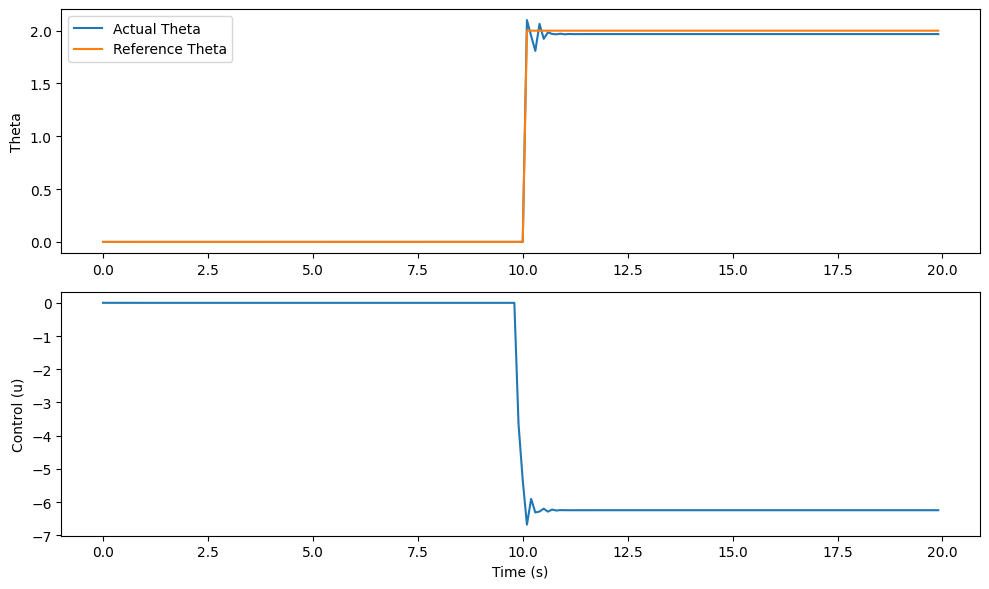

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensoraerospace.agent.mpc.base import AircraftMPC

# Предположим, что dynamics_nn - это ваша нейросетевая модель
# (определение dynamics_nn не включено в пример, так как оно не менялось)
# ...

# Инициализация MPC
mpc = AircraftMPC(dynamics_nn.model, horizon=2, dt=0.1)

# Параметры симуляции
simulation_time = 20 # Уменьшено время симуляции
dt = 0.1
steps = int(simulation_time / dt)

# Начальное состояние
x0 = np.array([0, 0, 0, 0])
states = [x0]
controls = []

# Генерация опорной траектории (синусоида с периодом 2 секунды)
time = np.arange(steps + mpc.horizon + 1) * dt
theta_ref = unit_step(degree=2, tp=time, time_step=0.1, output_rad=False)
# theta_ref = np.sin(1 * time)

A = torch.tensor([
            [-0.0212, 0.0466,    0,   0.1153],
            [-0.2229, -0.5839, 0.9404, 0],
            [0.0150,  -0.5031, -0.5015, 0],
            [0, 0, 1, 0],
        ], dtype=torch.float32)
        
B = torch.tensor([
            [0],
            [-0.0340],
            [-0.5746],
            [0]
        ], dtype=torch.float32)
        
        # Генерация выходных данных
model_states = [torch.tensor([0, 0, 0, 0], dtype=torch.float32)]
    

# Цикл управления
for i in tqdm(range(steps)):
    current_ref = theta_ref[i:i + mpc.horizon + 1]
    u_opt, predicted_states = mpc.optimize_control(states[-1], current_ref)
    next_states = A @ model_states[i] + B @ torch.tensor(u_opt, dtype=torch.float32)

    controls.append(u_opt)
    model_states.append(next_states)
    # Обновляем состояние системы на основе предсказанного моделью (не используем шум)
    # next_state = predicted_states[0]
    states.append(next_states)

# Визуализация результатов
time_array = np.arange(0, simulation_time, dt)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time_array, [s[3] for s in states[:-1]], label="Actual Theta")
plt.plot(time_array, theta_ref[:steps], label="Reference Theta")
plt.ylabel("Theta")
# plt.ylim([0, 1.2])
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_array, controls)
plt.xlabel("Time (s)")
plt.ylabel("Control (u)")

plt.tight_layout()
plt.show()

In [11]:
from tensoraerospace.benchmark import ControlBenchmark
bench = ControlBenchmark()
res = bench.becnchmarking_one_step(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 1.9, dt)


In [12]:
print("Статическая ошибка: ", res['static_error'])
print("Время переходного процесса: ", res['settling_time'], "сек")
print("Степень затухания: ", res['damping_degree'])
print("Перерегулирование: ", res['overshoot'])


Статическая ошибка:  0.03220049142837533
Время переходного процесса:  0.30000000000000004 сек
Степень затухания:  0.0014316554503416693
Перерегулирование:  5.013108253479004


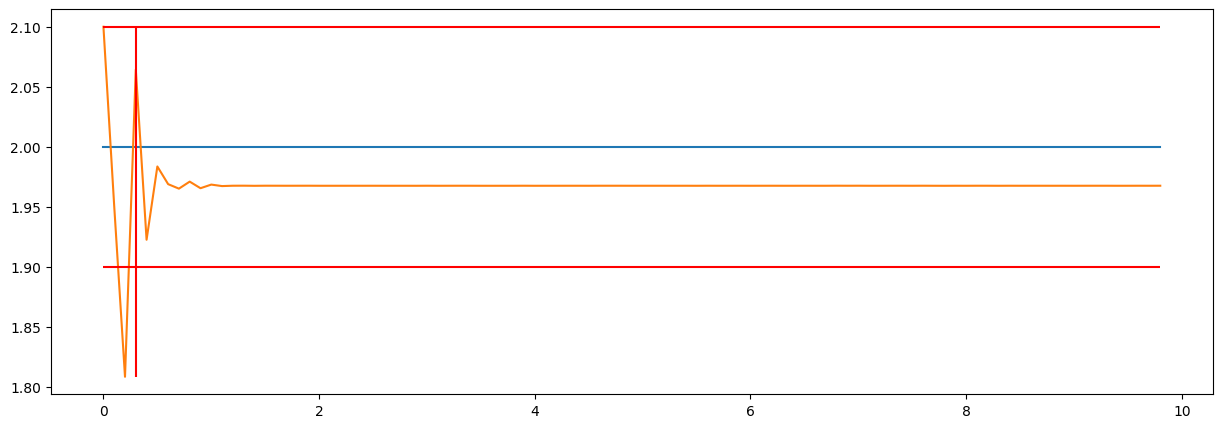

In [13]:
bench.plot(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 0.9, dt, time, figsize=(15,5))
